In [180]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as st
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV, LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer, LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR

from sklearn.model_selection import cross_val_score
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

# Обработка данных

In [181]:
def plot_df(df):
  empty_values = pd.DataFrame(df.apply(lambda x: x.isna().sum()/df.shape[0]).sort_values(ascending = False),
                            columns = ['empty'])
  empty_values.plot(kind = 'bar', figsize = (15,8))

In [182]:
df = pd.read_csv('Исходные данные.csv', sep=';',
                 error_bad_lines=False,
                 parse_dates=['DT'],
                 decimal=',', index_col=['Unnamed: 0'])

for col in df.select_dtypes(['float64', 'int64']).columns:
    df[col] = df[col].astype('float64')

In [183]:
df.shape

(7041, 84)

Удалим столбцы, в которых больше 80% отсутствующих значений

In [184]:
empty_values = pd.DataFrame(df.apply(lambda x: x.isna().sum()/df.shape[0]).sort_values(ascending = False),
                            columns = ['empty'])
drop_empty_col = empty_values[empty_values['empty'] > 0.8].index

df.drop(drop_empty_col, axis = 1, inplace = True)

In [185]:
uniq_value = df.apply(lambda x: len(x.unique())).sort_values()

In [186]:
df.drop(uniq_value.index[:2], axis = 1, inplace = True)

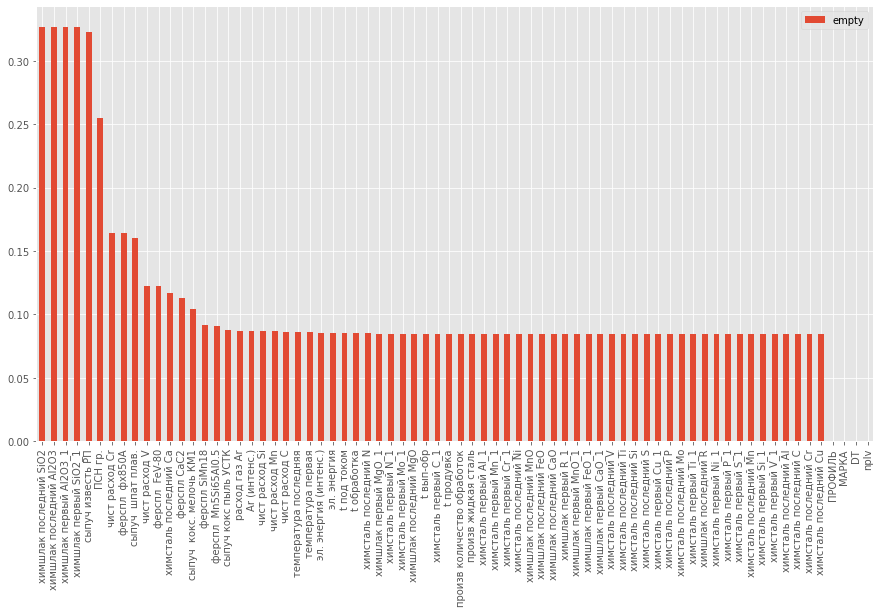

In [187]:
plot_df(df)

Есть еще 4 важных для анализа столбца с большим кол-вом пропущенных значений, которые мы не решились удалить. Обработаем их отдельно

In [188]:
q_df = df[['химшлак последний SiO2', 'химшлак последний Al2O3', 'химшлак первый SiO2_1', 'химшлак первый Al2O3_1']]
df.drop(q_df, axis = 1, inplace = True)

In [189]:
future_col = [col for col in df.columns if 'последний' in col or 'последняя' in col]
target_col = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']
present_col = [col for col in df.columns if 'последний' not in col and 'последняя' not in col]
not_target_col = [col for col in df.columns if col not in target_col]

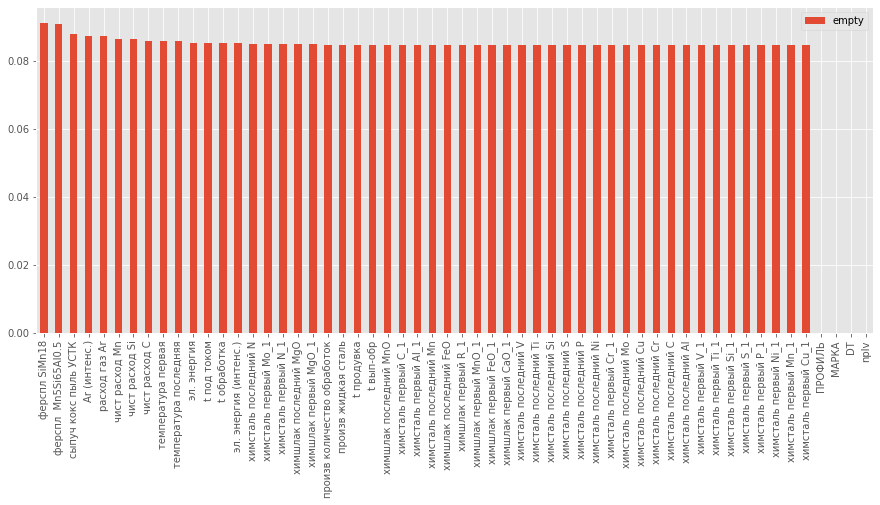

In [190]:
empty_values2 = pd.DataFrame(df[not_target_col].apply(lambda x: x.isna().sum()/df.shape[0]).sort_values(ascending = False),
                            columns = ['empty'])
res_df = empty_values2[empty_values2['empty'] < 0.1]
res_df.plot(kind = 'bar',figsize = (15,6))

In [191]:
all_col = list(res_df.index)


In [192]:
new1=df[all_col].dropna(inplace = False)

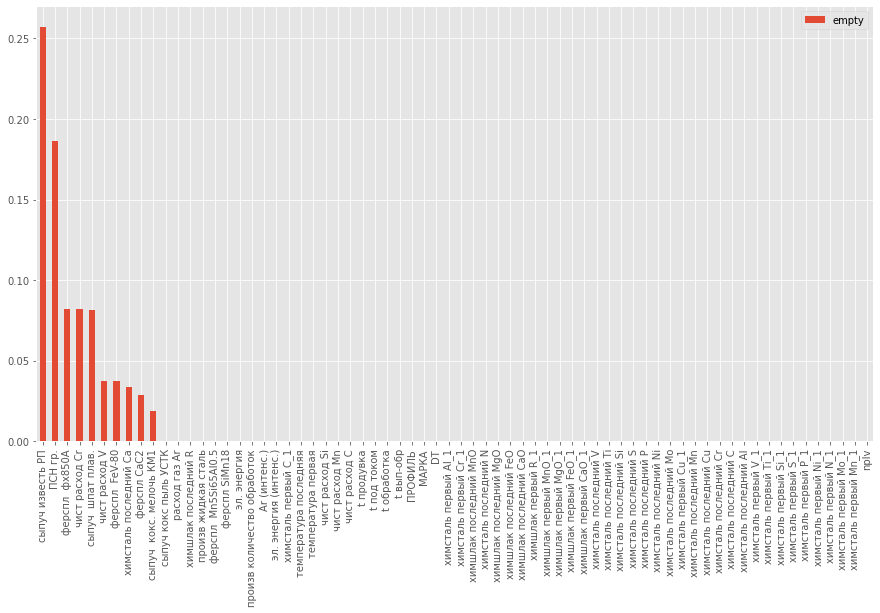

In [193]:
plot_df(df.iloc[new1.index,:])

In [194]:
df = df.iloc[new1.index,:]

In [195]:
df.shape

(6328, 68)

NA остались только либо в целевых, либо в важных для нас колонках

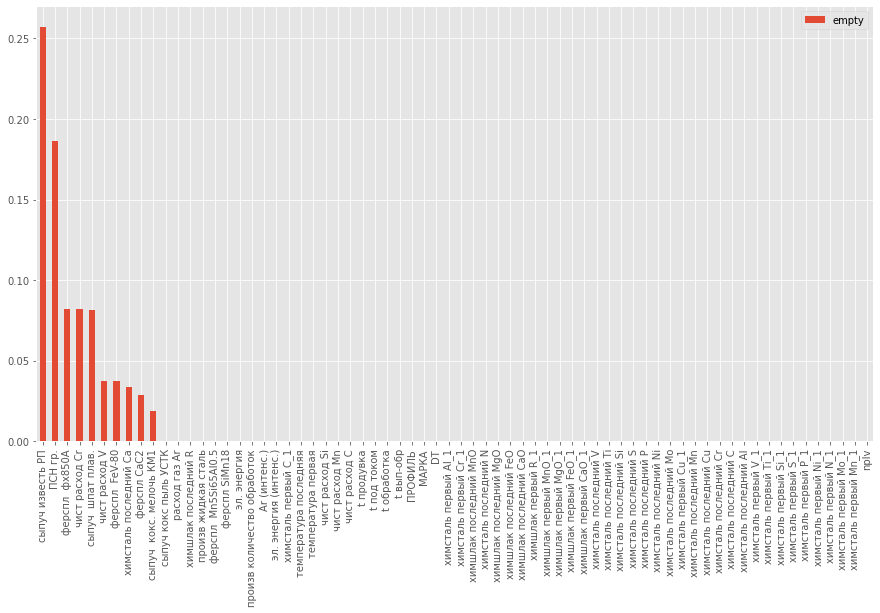

In [196]:
plot_df(df)

In [197]:
df.isna().sum().sort_values().tail(10)

сыпуч  кокс. мелочь КМ1     119
ферспл CaC2                 181
химсталь последний Ca       214
ферспл  FeV-80              235
чист расход V               236
сыпуч  шпат плав.           515
чист расход Cr              521
ферспл  фх850А              521
ПСН гр.                    1178
сыпуч известь РП           1626
dtype: int64

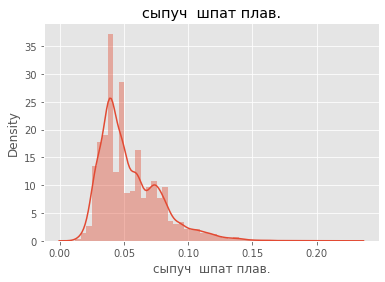

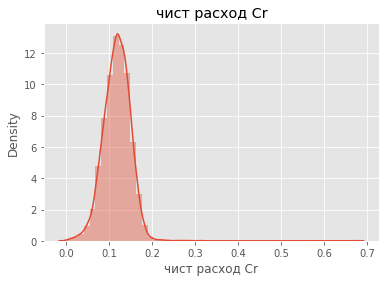

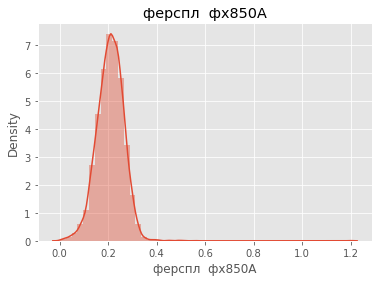

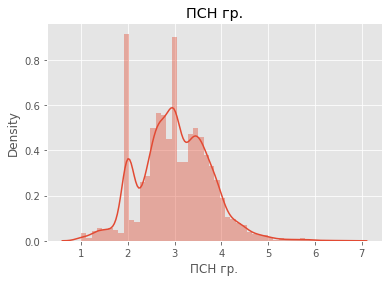

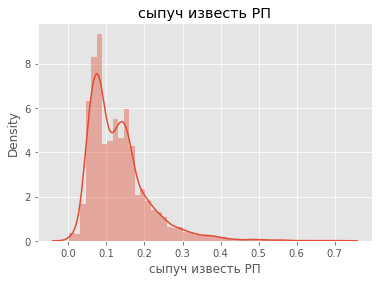

In [198]:
# смотрим на оставшиееся колонки

for col in df.isna().sum().sort_values().tail(5).index:
    plt.title(col)
    sns.distplot(df[col])
    plt.show()

In [199]:
# удалим колонки где нет норм распредления
df.drop(['ферспл  FeV-80', 'чист расход V', 'сыпуч  шпат плав.', 'ПСН гр.', 'сыпуч известь РП'], axis = 1, inplace = True)

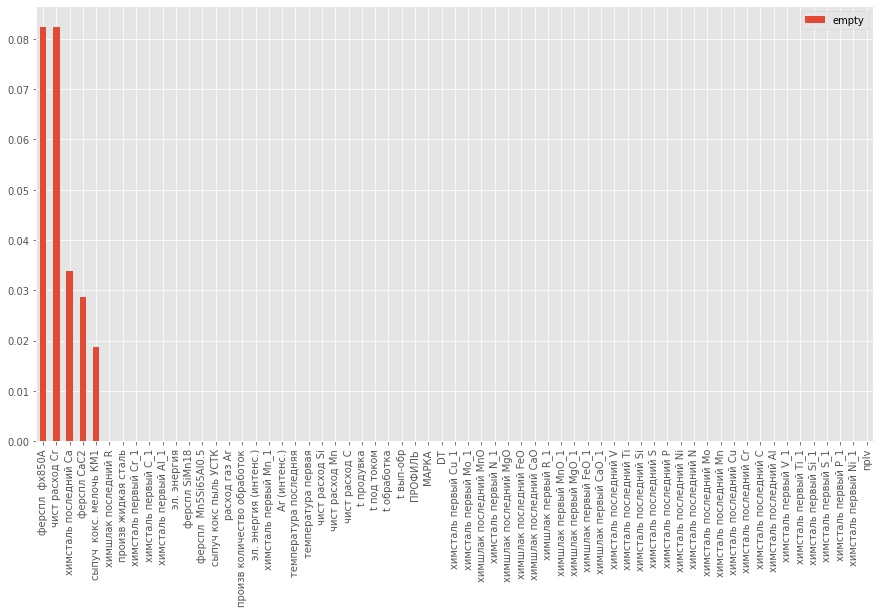

In [200]:
plot_df(df)

In [201]:
# заменим в остальных столбцах на среднее по столбцам
for col in df.isna().sum().sort_values().tail(5).index:
  df[col] = df[col].fillna(df[col].mean())

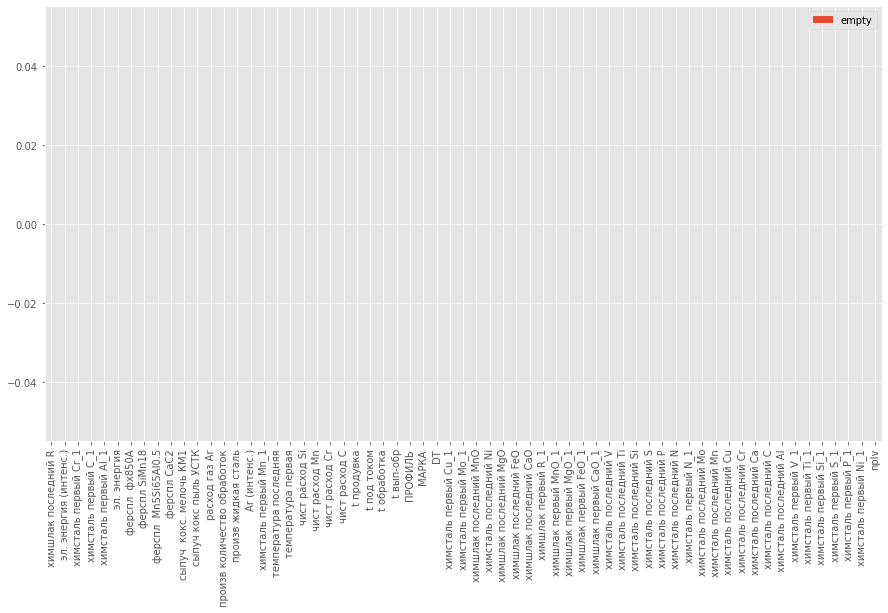

In [202]:
plot_df(df)

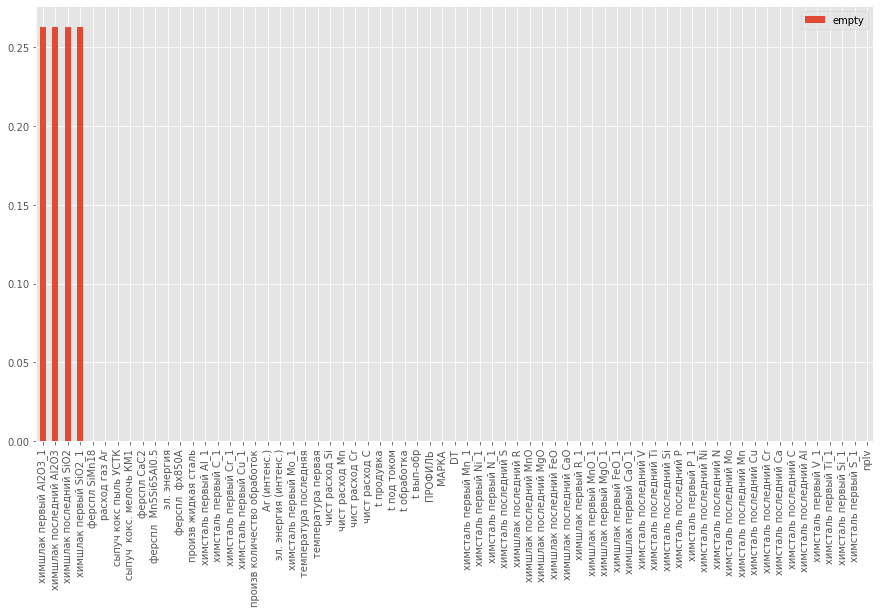

In [203]:
df = df.join(q_df.iloc[df.index,:])
plot_df(df)

In [204]:
df.shape

(6328, 67)

In [205]:
data = df.copy()
data.shape

(6328, 67)

In [206]:
data['ПРОФИЛЬ'] = data['ПРОФИЛЬ'].replace(['НЛЗ 300х365', '60E2', 'Шар заг d шара 100 мм 2 гр.',
                                           'Швеллер 40У (12 категория)','Швеллер 40У', 'ОР50', 'НЕТ'], 'Другое')

In [207]:
for col in pd.get_dummies(df['ПРОФИЛЬ']).columns:
  data[col] = pd.get_dummies(df['ПРОФИЛЬ'])[col]

In [208]:
for col in pd.get_dummies(df['МАРКА']).columns:
  data[col] = pd.get_dummies(df['МАРКА'])[col]

In [209]:
# удаляем столбец профиль
data.drop(['ПРОФИЛЬ'], axis = 1, inplace = True)
data.drop(['МАРКА'], axis = 1, inplace = True)
data.drop(['DT', 'nplv'], axis = 1, inplace = True)

In [210]:
data['химшлак первый Al2O3_1'] = data['химшлак первый Al2O3_1'].fillna(data['химшлак первый Al2O3_1'].mean())
data['химшлак первый SiO2_1'] = data['химшлак первый SiO2_1'].fillna(data['химшлак первый SiO2_1'].mean())

In [211]:
data

,t вып-обр,t обработка,t под током,t продувка,чист расход C,чист расход Cr,чист расход Mn,чист расход Si,температура первая,температура последняя,Ar (интенс.),эл. энергия (интенс.),произв жидкая сталь,произв количество обработок,расход газ Ar,сыпуч кокс пыль УСТК,сыпуч кокс. мелочь КМ1,ферспл CaC2,ферспл Mn5Si65Al0.5,ферспл SiMn18,ферспл фх850А,эл. энергия,химсталь первый Al_1,химсталь первый C_1,химсталь первый Cr_1,химсталь первый Cu_1,химсталь первый Mn_1,химсталь первый Mo_1,химсталь первый N_1,химсталь первый Ni_1,химсталь первый P_1,химсталь первый S_1,химсталь первый Si_1,химсталь первый Ti_1,химсталь первый V_1,химсталь последний Al,химсталь последний C,химсталь последний Ca,химсталь последний Cr,химсталь последний Cu,...,химшлак первый MnO_1,химшлак первый R_1,химшлак последний CaO,химшлак последний FeO,химшлак последний MgO,химшлак последний MnO,химшлак последний R,химшлак последний SiO2,химшлак последний Al2O3,химшлак первый SiO2_1,химшлак первый Al2O3_1,136 RE,540,600,UIC54,НЕТ,ОР50,ОР65,Р50,Р65,Рельсы трамвайные,Шар заг d шара 100 мм 2 гр.,"Шар заг d шара 80-100 мм 2,3 гр.",Шар заг d шара 80-100 мм 4 гр.,Шары мелющие d 80-100 мм,Швеллер 40У,900А,G2HH,R260,R350HT,НХ,С255,Ш2.2,Ш2Л,Э73Ф,Э76,Э76Ф,Э76ХАФ,Э76ХФ,Э90ХАФ
0,29.0,45.366667,24.400000,41.033333,0.456460,0.059572,0.117446,0.104762,1557.0,1580.0,13.606742,12809.01639,115.5,1.0,18.611,0.170,0.401000,0.02,0.112,0.182,0.106,5209.0,0.002,0.389,0.368,0.127,0.682,0.010,0.011,0.086,0.009,0.023,0.459,0.002,0.002,0.003,0.756,0.0001,0.417,0.126,...,0.12,2.6,53.4,1.0,5.8,0.15,2.6,NaN,NaN,22.712752,4.103279,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,26.0,44.066667,13.866667,44.066667,0.359285,0.083738,0.160923,0.110327,1601.0,1591.0,8.074721,12816.34615,111.6,1.0,11.659,0.488,0.420318,0.02,0.102,0.251,0.149,2962.0,0.002,0.465,0.345,0.112,0.643,0.009,0.011,0.080,0.007,0.023,0.461,0.002,0.002,0.003,0.774,0.0003,0.416,0.109,...,0.14,2.2,59.3,0.6,4.1,0.11,2.3,NaN,NaN,22.712752,4.103279,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,24.0,43.350000,17.950000,43.350000,0.331665,0.081490,0.132332,0.139860,1593.0,1586.0,13.801968,12511.42061,115.8,1.0,19.871,0.050,0.346000,0.02,0.160,0.204,0.145,3743.0,0.002,0.513,0.351,0.107,0.674,0.007,0.011,0.078,0.008,0.019,0.455,0.002,0.002,0.004,0.770,0.0009,0.417,0.108,...,0.12,2.6,57.2,0.5,8.1,0.13,2.3,NaN,NaN,22.712752,4.103279,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,17.0,46.183333,19.816667,46.183333,0.377945,0.133194,0.221605,0.165186,1589.0,1589.0,12.664959,12998.14971,116.3,1.0,19.497,0.050,0.390000,0.02,0.161,0.345,0.237,4293.0,0.002,0.487,0.310,0.105,0.611,0.009,0.011,0.070,0.006,0.020,0.434,0.001,0.001,0.003,0.767,0.0002,0.419,0.103,...,0.11,2.4,60.3,0.5,6.3,0.12,2.6,NaN,NaN,22.712752,4.103279,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,20.0,48.500000,17.033333,48.500000,0.389875,0.105094,0.169459,0.143024,1597.0,1592.0,10.298350,12987.47554,115.0,1.0,16.649,0.050,0.412000,0.02,0.149,0.263,0.187,3687.0,0.002,0.461,0.334,0.105,0.652,0.007,0.011,0.080,0.007,0.020,0.447,0.001,0.002,0.003,0.784,0.0003,0.421,0.105,...,0.12,2.4,60.3,0.6,4.5,0.09,2.5,NaN,NaN,22.712752,4.103279,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7036,41.0,42.333333,23.200000,42.166667,0.537080,0.105640,0.128626,0.101552,1552.0,1582.0,10.015635,13388.79310,114.4,1.0,7.189,0.050,0.595000,0.02,0.104,0.199,0.190,5177.0,0.002,0.432,0.212,0.094,0.675,0.008,0.009,0.080,0.007,0.017,0.442,0.002,0.003,0.004,0.854,0.0003,0.301,0.092,...,0.10,2.6,60.6,0.4,6.2,0.06,2.7,22.8,7.0,22.200000,5.600000,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
7037,36.0,46.533333,16.18

In [212]:
future_col = [col for col in data.columns if 'последний' in col or 'последняя' in col]
target_col = ['химшлак последний Al2O3', 'химшлак последний CaO', 'химшлак последний R', 'химшлак последний SiO2']
present_col = [col for col in data.columns if 'последний' not in col and 'последняя' not in col]
not_target_col = [col for col in data.columns if col not in target_col]

# Модели

## Предсказываем химшлак последний Аl203

In [213]:
k=0

In [214]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
models,R2, MAE, MSE, MAPe=[],[],[],[],[]

In [215]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [216]:
# видим, что Аl203 имеет нормальное распределение, поэтому можно заменить пропуски на среднее

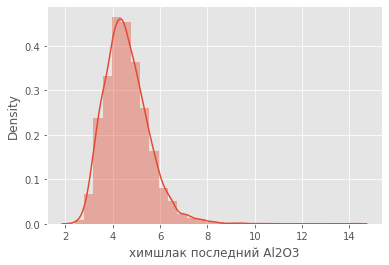

In [217]:
sns.distplot(data[target_col[k]], bins = 30)

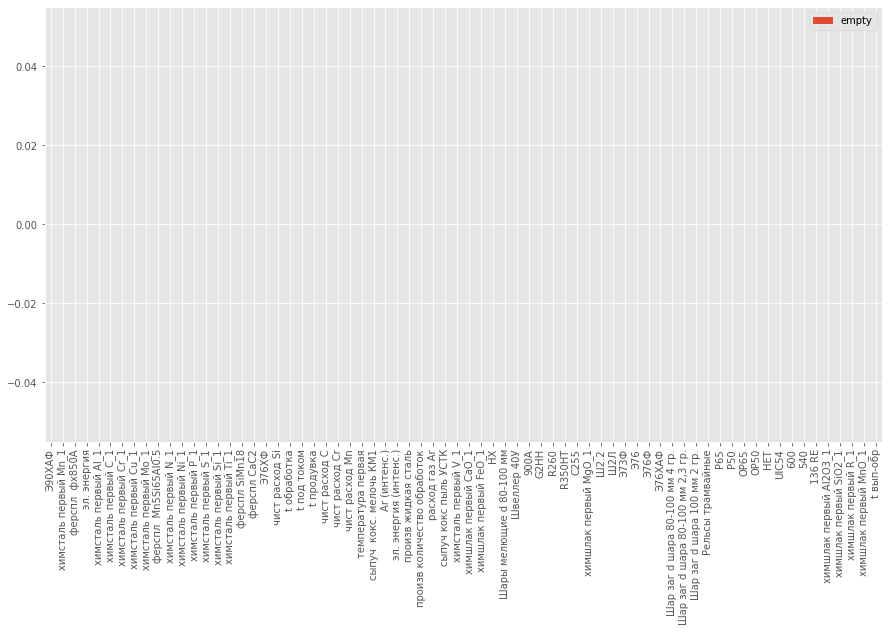

In [218]:
X = data[present_col][data[target_col[k]].notnull()]
plot_df(X)

In [219]:
y = data.loc[X.index,target_col[k]]
y

463     5.7
589     3.2
1029    4.7
1036    5.4
1345    5.2
       ... 
7036    7.0
7037    4.9
7038    5.2
7039    4.9
7040    5.4
Name: химшлак последний Al2O3, Length: 4666, dtype: float64

In [220]:
num_scaler = StandardScaler()

for col in X.columns:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [221]:
def get_data(X, y):
  X_train, X_test, y_train, y_test = train_test_split(
  X, y, test_size=0.8, random_state=42)
  X_train, X_valid, y_train, y_valid = train_test_split(
  X_train, y_train, test_size=0.5, random_state=42)

  return  X_train, X_valid, X_test, y_train, y_valid, y_test 

In [222]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(X,y)

In [78]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=50, random_state=42)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.9061649347684844
0.3921106468413723


In [81]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth': range(1,40,3),
              'min_samples_leaf':range(1,40,3),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,2)]}
rfc = RandomForestRegressor(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 338 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:  4.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [82]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 13, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


0.3129197318801166

In [83]:
import matplotlib.pyplot as plt


def show_parameter_selection(train_acc, test_acc, grid, xlabel, ymin=0.8, ymax=1.005):
    #выводит график train_acc, test_acc
    plt.style.use('ggplot')
    %matplotlib inline
    train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.plot(grid, train_acc, alpha=0.5, color='blue', label='train')
    ax.plot(grid, test_acc, alpha=0.5, color='red', label='test')
    ax.set_title("Подбор " + xlabel)
    ax.legend(loc='best')
    ax.set_ylim([ymin,ymax])
    ax.set_ylabel("r2")
    ax.set_xlabel(xlabel)

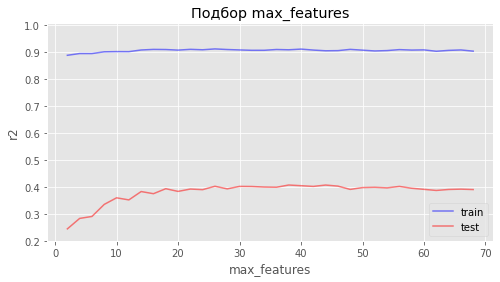

In [84]:
train_acc = []
test_acc = []
max_features_grid = range(2,X_train.shape[1],2)
for max_features in max_features_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.2)   

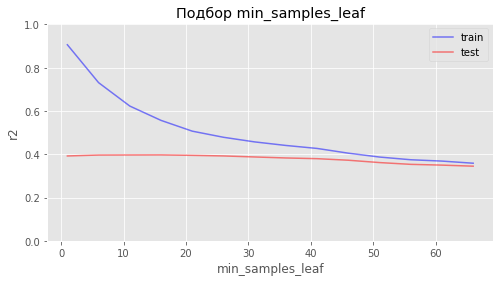

In [85]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(1,70,5)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0)   

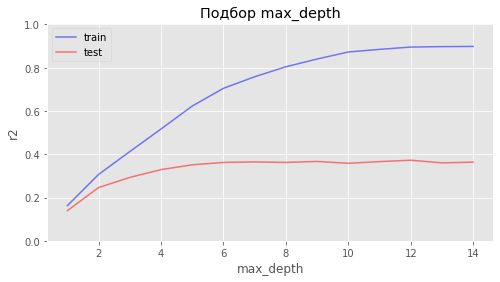

In [86]:
train_acc = []
test_acc = []
max_depth_grid = range(1,15)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0)   

Лучший RandomForestRegressor

In [223]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=40,min_samples_leaf=40,max_depth=4,n_jobs=-1)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
print("Cross_val_score:",cross_val_score(rf, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for rf: 0.4216241640952805
Test score for rf: 0.3798564656535949
MSE for rf: 0.5503524200757175
Cross_val_score: 0.35813784037280605


In [224]:
models.append("RandomForestRegressor")
R2.append(r2_score(y_test, rf_predict))
MAE.append(mean_absolute_error(y_test, rf.predict(X_test)))
MSE.append(mean_squared_error(y_test, rf.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, rf.predict(X_test)))


In [225]:
en=ElasticNetCV()
en.fit(X_train, y_train)
en_predict = en.predict(X_test)

print("Train score for en:",en.score(X_train, y_train)) 
print("Test score for en:",en.score(X_test, y_test))  
print("MSE for en:",mean_squared_error(y_test, en.predict(X_test)))
print("Cross_val_score:",cross_val_score(en, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for en: 0.4620077653384122
Test score for en: 0.39916525597744534
MSE for en: 0.5332166460251737
Cross_val_score: 0.25692242169411295


In [226]:
models.append("ElasticNetCV")
R2.append(r2_score(y_test, en_predict))
MAE.append(mean_absolute_error(y_test, en.predict(X_test)))
MSE.append(mean_squared_error(y_test, en.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, en.predict(X_test)))


In [96]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=40,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.4027720535680807
Score обучающей: 1.0
MSE for DT: 0.5300157583712832
[0.34594776 0.48540512 0.2637711  0.2940784 ]
Avg crossval score: 0.3473005946820733


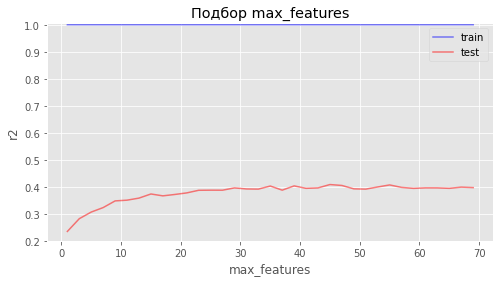

In [98]:
train_acc = []
test_acc = []
max_features_grid = range(1,X_train.shape[1],2)
for max_features in max_features_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.2)   

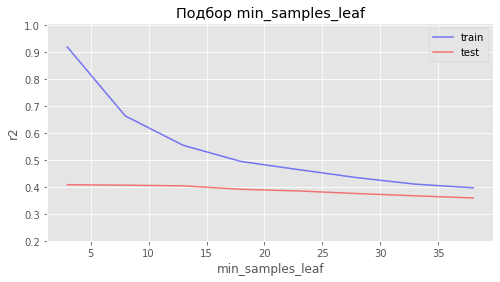

In [99]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(3,40,5)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = ExtraTreesRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0.2)   

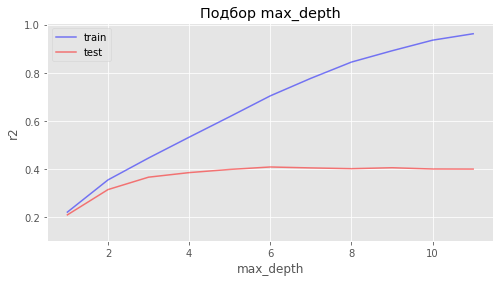

In [100]:
train_acc = []
test_acc = []
max_depth_grid = range(1,12)
for max_depth in max_depth_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_depth=max_depth, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_depth_grid,"max_depth",ymin=0.1)   

In [101]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'max_depth': range(1,40,3),
              'min_samples_leaf':range(1,40,3),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,2)]}
rfc = ExtraTreesRegressor(random_state=42, 
                             n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 338 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   24.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:  3.2min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=-1,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_gri

In [102]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 25, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


0.3027154408431832

In [227]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(max_features=40,min_samples_leaf=40,max_depth=4,n_jobs=-1)
xtr.fit(X_train, y_train)
xtr_predict = xtr.predict(X_test)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.2709466477188949
Score обучающей: 0.2964507166478585
MSE for DT: 0.6470054988400393
[0.19772311 0.26101325 0.22186256 0.23544117]
Avg crossval score: 0.22759598026205555


In [228]:
models.append("ExtraTreesRegressor")
R2.append(r2_score(y_test, xtr_predict))
MAE.append(mean_absolute_error(y_test, xtr.predict(X_test)))
MSE.append(mean_squared_error(y_test, xtr.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, xtr.predict(X_test)))


In [229]:
print(target_col[k])
pd.DataFrame({'r2':R2,'MAE':MAE,'MSE':MSE,'MAPe':MAPe},index=models)

химшлак последний Al2O3


,r2,MAE,MSE,MAPe
RandomForestRegressor,0.379856,0.539377,0.550352,11.980632
ElasticNetCV,0.399165,0.521967,0.533217,11.585064
ExtraTreesRegressor,0.270947,0.598050,0.647005,13.409146


In [230]:
df['МАРКА'].value_counts().index[0]

'Э76ХФ'

Мы считаем, что в первую очередь следует пользоваться метрикой r2. Наибольшее значение метрики у ElasticNetCV, выбираем её.

In [232]:
popular_mark=data[data['Э76ХФ']==1]
X_popular = popular_mark[present_col][popular_mark[target_col[k]].notnull()]
y_popular = popular_mark.loc[X_popular.index,target_col[k]]

num_scaler = StandardScaler()

for col in X_popular.columns:
  X_popular[[col]] = num_scaler.fit_transform(X_popular[[col]])

In [233]:
en_pred=en.predict(X_popular)
pred_df=pd.DataFrame({'true':y_popular,'pred':en_pred})
pred_df

,true,pred
589,3.2,3.838313
1345,5.2,5.357362
1348,4.4,4.701411
1662,4.5,5.445456
1663,4.8,5.253978
...,...,...
7022,6.6,4.663603
7023,5.0,4.759562
7024,6.2,5.287423
7025,5.4,5.418318


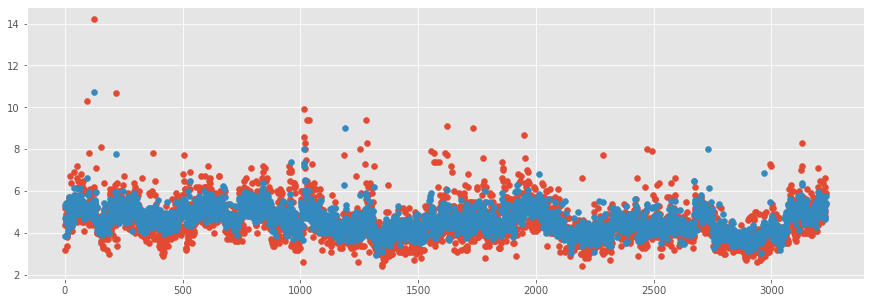

In [234]:
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'])
plt.scatter(range(pred_df.shape[0]),pred_df['pred'])

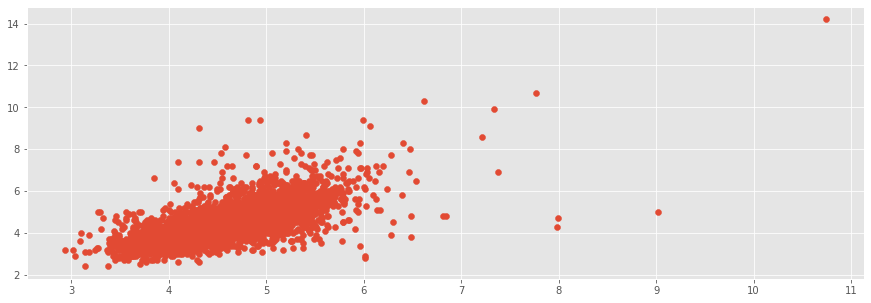

In [235]:
plt.figure(figsize=(15,5))
plt.scatter(pred_df['pred'],pred_df['true'])

## Предсказываем химшлак последний CaO

In [263]:
k=1

In [264]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
models,R2, MAE, MSE, MAPe=[],[],[],[],[]

In [265]:
# видим, что CaO имеет нормальное распределение, поэтому можно заменить пропуски на среднее

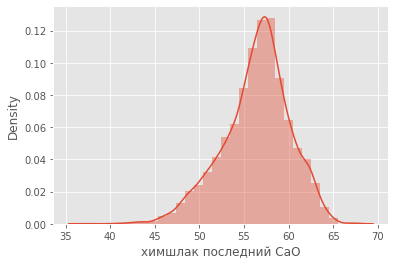

In [266]:
sns.distplot(data[target_col[k]], bins = 30)

In [267]:
X = data[present_col][data[target_col[k]].notnull()]

In [268]:
y = data.loc[X.index,target_col[k]]
y

0       53.4
1       59.3
2       57.2
3       60.3
4       60.3
        ... 
7036    60.6
7037    53.0
7038    55.4
7039    55.1
7040    57.3
Name: химшлак последний CaO, Length: 6328, dtype: float64

In [269]:
num_scaler = StandardScaler()

for col in X.columns:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [270]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(X,y)

In [244]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=50, random_state=42)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.8732903034928081
0.1550518143834957


In [245]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth': range(1,40,3),
              'min_samples_leaf':range(1,40,3),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,2)]}
rfc = RandomForestRegressor(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 338 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   34.9s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:  4.5min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [246]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 100}


0.17543984743037583

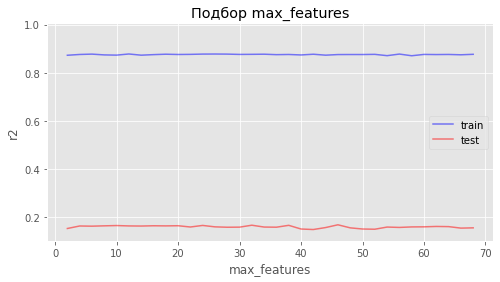

In [247]:
train_acc = []
test_acc = []
max_features_grid = range(2,X_train.shape[1],2)
for max_features in max_features_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.1)   

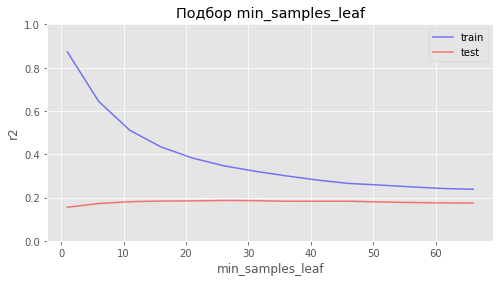

In [248]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(1,70,5)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0)   

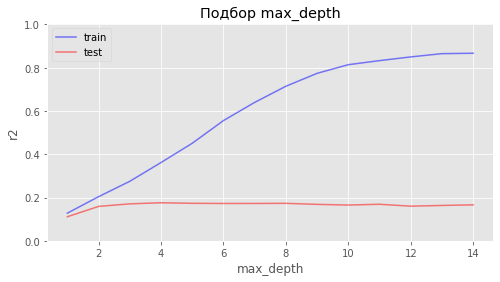

In [249]:
train_acc = []
test_acc = []
max_depth_grid = range(1,15)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0)   

Лучший RandomForestRegressor

In [271]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=40,min_samples_leaf=60,max_depth=4,n_jobs=-1)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
print("Cross_val_score:",cross_val_score(rf, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for rf: 0.2410364093074322
Test score for rf: 0.17509549950588765
MSE for rf: 11.496948085752118
Cross_val_score: 0.1384332995913562


In [272]:
models.append("RandomForestRegressor")
R2.append(r2_score(y_test, rf_predict))
MAE.append(mean_absolute_error(y_test, rf.predict(X_test)))
MSE.append(mean_squared_error(y_test, rf.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, rf.predict(X_test)))


In [273]:
en=ElasticNetCV()
en.fit(X_train, y_train)
en_predict = en.predict(X_test)

print("Train score for en:",en.score(X_train, y_train)) 
print("Test score for en:",en.score(X_test, y_test))  
print("MSE for en:",mean_squared_error(y_test, en.predict(X_test)))
print("Cross_val_score:",cross_val_score(en, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for en: 0.2222587330543352
Test score for en: 0.17527929530035757
MSE for en: 11.494386467157316
Cross_val_score: 0.1527327237725309


In [274]:
models.append("ElasticNetCV")
R2.append(r2_score(y_test, en_predict))
MAE.append(mean_absolute_error(y_test, en.predict(X_test)))
MSE.append(mean_squared_error(y_test, en.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, en.predict(X_test)))


In [254]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=40,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.16741478397814824
Score обучающей: 1.0
MSE for DT: 11.603996583646062
[0.07014134 0.18730817 0.19537571 0.1849242 ]
Avg crossval score: 0.15943735449831598


In [255]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'max_depth': range(1,40,3),
              'min_samples_leaf':range(1,40,3),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,2)]}
rfc = ExtraTreesRegressor(random_state=42, 
                             n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 338 candidates, totalling 1690 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 796 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1246 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1690 out of 1690 | elapsed:  3.3min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=-1,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_gri

In [256]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 28, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


0.15758144415472014

In [275]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(max_features=40,min_samples_leaf=60,max_depth=4,n_jobs=-1)
xtr.fit(X_train, y_train)
xtr_predict = xtr.predict(X_test)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.15150009644730467
Score обучающей: 0.18677818278083969
MSE for DT: 11.825804485328593
[0.09378806 0.14775716 0.12799794 0.14956146]
Avg crossval score: 0.13296123444731942


In [276]:
models.append("ExtraTreesRegressor")
R2.append(r2_score(y_test, xtr_predict))
MAE.append(mean_absolute_error(y_test, xtr.predict(X_test)))
MSE.append(mean_squared_error(y_test, xtr.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, xtr.predict(X_test)))


Наибольшее значение метрики у ElasticNetCV, выбираем её

In [277]:
print(target_col[k])
pd.DataFrame({'r2':R2,'MAE':MAE,'MSE':MSE,'MAPe':MAPe},index=models)

химшлак последний CaO


,r2,MAE,MSE,MAPe
RandomForestRegressor,0.175095,2.636829,11.496948,4.797234
ElasticNetCV,0.175279,2.640938,11.494386,4.803415
ExtraTreesRegressor,0.151500,2.661902,11.825804,4.840674


In [279]:
popular_mark=data[data['Э76ХФ']==1]
X_popular = popular_mark[present_col][popular_mark[target_col[k]].notnull()]
y_popular = popular_mark.loc[X_popular.index,target_col[k]]

num_scaler = StandardScaler()

for col in X_popular.columns:
  X_popular[[col]] = num_scaler.fit_transform(X_popular[[col]])

In [280]:
en_pred=en.predict(X_popular)
pred_df=pd.DataFrame({'true':y_popular,'pred':en_pred})
pred_df

,true,pred
0,53.4,58.347947
1,59.3,57.060021
2,57.2,57.604302
3,60.3,57.545040
4,60.3,57.640236
...,...,...
7022,56.1,54.889547
7023,57.5,55.691951
7024,58.0,55.632770
7025,52.1,55.699148


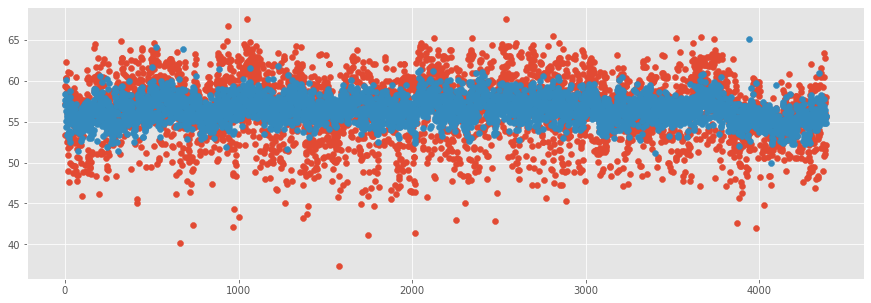

In [281]:
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'])
plt.scatter(range(pred_df.shape[0]),pred_df['pred'])

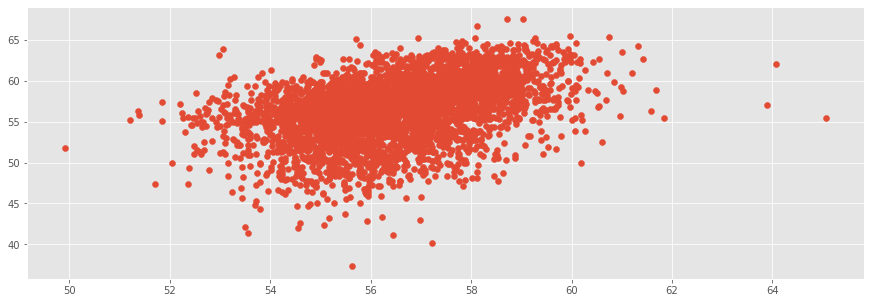

In [282]:
plt.figure(figsize=(15,5))
plt.scatter(pred_df['pred'],pred_df['true'])

## Предсказываем химшлак последний R

In [341]:
k=2

In [342]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
models,R2, MAE, MSE, MAPe=[],[],[],[],[]

In [343]:
# видим, что CaO имеет нормальное распределение, поэтому можно заменить пропуски на среднее

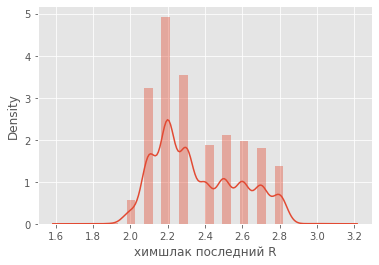

In [344]:
sns.distplot(data[target_col[k]], bins = 30)

In [345]:
X = data[present_col][data[target_col[k]].notnull()]

In [346]:
y = data.loc[X.index,target_col[k]]
y

0       2.6
1       2.3
2       2.3
3       2.6
4       2.5
       ... 
7036    2.7
7037    2.4
7038    2.2
7039    2.1
7040    2.3
Name: химшлак последний R, Length: 6328, dtype: float64

In [347]:
num_scaler = StandardScaler()

for col in X.columns:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [348]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(X,y)

In [291]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=50, random_state=42)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.9056254190888265
0.30064593046826105


In [293]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth': range(1,40,10),
              'min_samples_leaf':range(1,40,10),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,5)]}
rfc = RandomForestRegressor(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   26.1s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [294]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


0.35035315693627234

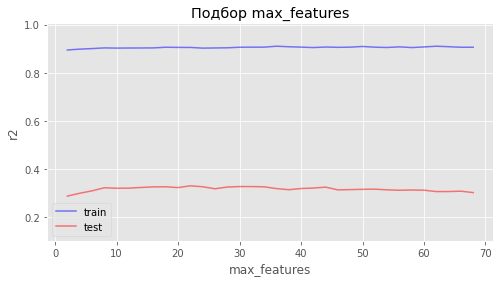

In [295]:
train_acc = []
test_acc = []
max_features_grid = range(2,X_train.shape[1],2)
for max_features in max_features_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.1)   

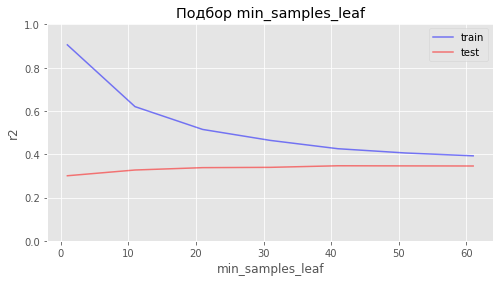

In [296]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(1,70,10)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0)   

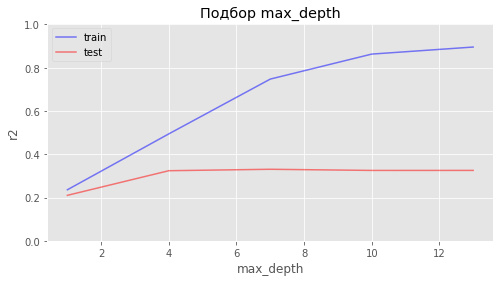

In [297]:
train_acc = []
test_acc = []
max_depth_grid = range(1,15,3)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0)   

Лучший RandomForestRegressor

In [349]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=12,min_samples_leaf=60,max_depth=4,n_jobs=-1)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
print("Cross_val_score:",cross_val_score(rf, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for rf: 0.351185914361422
Test score for rf: 0.3008404049013249
MSE for rf: 0.0349910563333277
Cross_val_score: 0.3004109773296907


In [350]:
models.append("RandomForestRegressor")
R2.append(r2_score(y_test, rf_predict))
MAE.append(mean_absolute_error(y_test, rf.predict(X_test)))
MSE.append(mean_squared_error(y_test, rf.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, rf.predict(X_test)))


In [351]:
en=ElasticNetCV()
en.fit(X_train, y_train)
en_predict = en.predict(X_test)

print("Train score for en:",en.score(X_train, y_train)) 
print("Test score for en:",en.score(X_test, y_test))  
print("MSE for en:",mean_squared_error(y_test, en.predict(X_test)))
print("Cross_val_score:",cross_val_score(en, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for en: 0.35756575158023174
Test score for en: 0.2985417715365347
MSE for en: 0.035106096747735065
Cross_val_score: 0.3722823651111139


In [352]:
models.append("ElasticNetCV")
R2.append(r2_score(y_test, en_predict))
MAE.append(mean_absolute_error(y_test, en.predict(X_test)))
MSE.append(mean_squared_error(y_test, en.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, en.predict(X_test)))


In [302]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=40,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.33355687252786836
Score обучающей: 1.0
MSE for DT: 0.03335368516689709
[0.44731254 0.26853433 0.38147097 0.36580654]
Avg crossval score: 0.3657810935182263


In [303]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'max_depth': range(1,40,10),
              'min_samples_leaf':range(1,40,10),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,10)]}
rfc = ExtraTreesRegressor(random_state=42, 
                             n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   18.8s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=-1,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_gri

In [304]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100}


0.35596491391776636

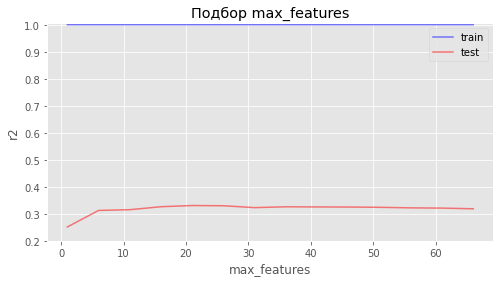

In [305]:
train_acc = []
test_acc = []
max_features_grid = range(1,X_train.shape[1],5)
for max_features in max_features_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0.2)   

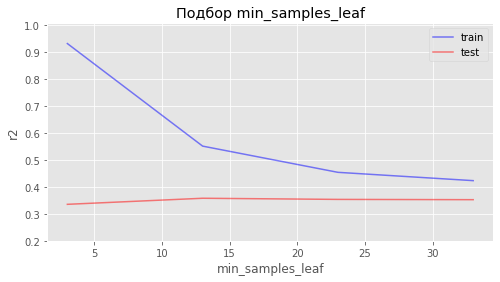

In [306]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(3,40,10)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = ExtraTreesRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0.2)   

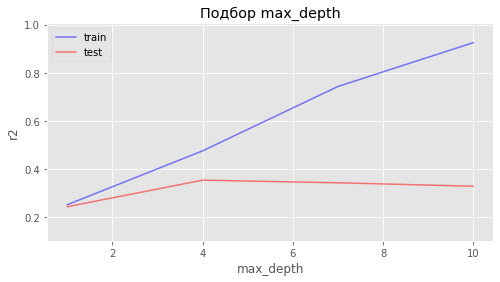

In [307]:
train_acc = []
test_acc = []
max_depth_grid = range(1,12,3)
for max_depth in max_depth_grid:
    xtr = ExtraTreesRegressor(n_estimators=50, random_state=42,max_depth=max_depth, n_jobs=-1)
    xtr.fit(X_train, y_train)
    train_acc.append(xtr.score(X_train, y_train))
    test_acc.append(xtr.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_depth_grid,"max_depth",ymin=0.1)   

In [353]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(max_features=20,min_samples_leaf=30,max_depth=4,n_jobs=-1)
xtr.fit(X_train, y_train)
xtr_predict = xtr.predict(X_test)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.2717513298469423
Score обучающей: 0.3101704438619025
MSE for DT: 0.03644688626264254
[0.3093897  0.21896538 0.25484097 0.31310641]
Avg crossval score: 0.2782449900597246


In [354]:
models.append("ExtraTreesRegressor")
R2.append(r2_score(y_test, xtr_predict))
MAE.append(mean_absolute_error(y_test, xtr.predict(X_test)))
MSE.append(mean_squared_error(y_test, xtr.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, xtr.predict(X_test)))


Наибольшее значение метрики у RandromForest, выбираем её

In [355]:
print(target_col[k])
pd.DataFrame({'r2':R2,'MAE':MAE,'MSE':MSE,'MAPe':MAPe},index=models)

химшлак последний R


,r2,MAE,MSE,MAPe
RandomForestRegressor,0.300840,0.156772,0.034991,6.611534
ElasticNetCV,0.298542,0.149899,0.035106,6.334304
ExtraTreesRegressor,0.271751,0.161477,0.036447,6.807295


In [356]:
popular_mark=data[data['Э76ХФ']==1]
X_popular = popular_mark[present_col][popular_mark[target_col[k]].notnull()]
y_popular = popular_mark.loc[X_popular.index,target_col[k]]

num_scaler = StandardScaler()

for col in X_popular.columns:
  X_popular[[col]] = num_scaler.fit_transform(X_popular[[col]])

In [357]:
rf_pred=rf.predict(X_popular)
pred_df=pd.DataFrame({'true':y_popular,'pred':rf_pred})
pred_df

,true,pred
0,2.6,2.476203
1,2.3,2.358430
2,2.3,2.435346
3,2.6,2.357374
4,2.5,2.387408
...,...,...
7022,2.3,2.234216
7023,2.5,2.395841
7024,2.3,2.351316
7025,2.3,2.366181


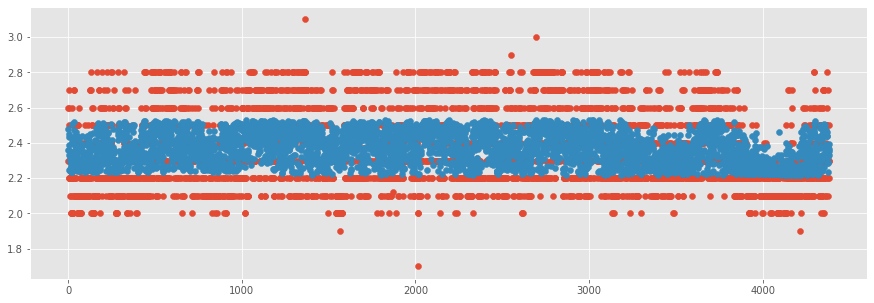

In [358]:
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'])
plt.scatter(range(pred_df.shape[0]),pred_df['pred'])

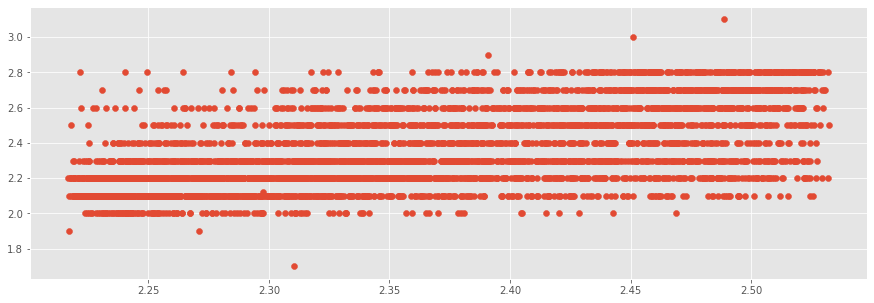

In [359]:
plt.figure(figsize=(15,5))
plt.scatter(pred_df['pred'],pred_df['true'])

## Предсказываем химшлак последний SiO2

In [360]:
k=3

In [316]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
models,R2, MAE, MSE, MAPe=[],[],[],[],[]

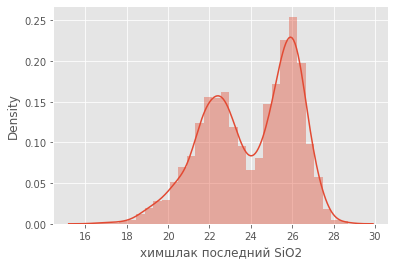

In [317]:
sns.distplot(data[target_col[k]], bins = 30)

In [318]:
X = data[present_col][data[target_col[k]].notnull()]

In [319]:
y = data.loc[X.index,target_col[k]]
y

463     26.0
589     23.2
1029    26.1
1036    24.2
1345    26.6
        ... 
7036    22.8
7037    22.3
7038    25.0
7039    26.0
7040    25.5
Name: химшлак последний SiO2, Length: 4666, dtype: float64

In [320]:
num_scaler = StandardScaler()

for col in X.columns:
  X[[col]] = num_scaler.fit_transform(X[[col]])

In [321]:
X_train, X_valid, X_test, y_train, y_valid, y_test = get_data(X,y)

In [322]:
from sklearn.ensemble import RandomForestRegressor
rfc = RandomForestRegressor(n_estimators=50, random_state=42)
rfc.fit(X_train, y_train)
print(rfc.score(X_train, y_train))
print(rfc.score(X_test, y_test))

0.86671060226134
0.09745574038317495


In [323]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

parameters = {'max_depth': range(1,40,10),
              'min_samples_leaf':range(1,40,10),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,7)]}
rfc = RandomForestRegressor(random_state=42, 
                             n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   24.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=True, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1

In [324]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 31, 'n_estimators': 100}


0.09064385516381779

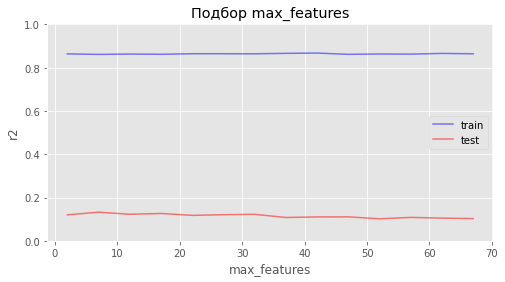

In [325]:
train_acc = []
test_acc = []
max_features_grid = range(2,X_train.shape[1],5)
for max_features in max_features_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=max_features, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc,test_acc,max_features_grid,"max_features",ymin=0)   

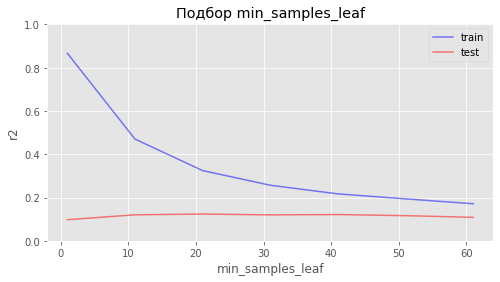

In [326]:
train_acc = []
test_acc = []
min_samples_leaf_grid = range(1,70,10)
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,
                                 min_samples_leaf=min_samples_leaf, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, min_samples_leaf_grid, "min_samples_leaf", ymin=0)   

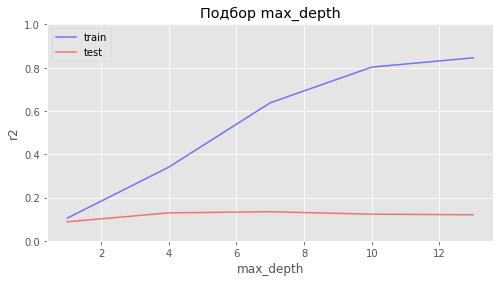

In [327]:
train_acc = []
test_acc = []
max_depth_grid = range(1,15,3)
for max_depth in max_depth_grid:
    rfc = RandomForestRegressor(n_estimators=50, random_state=42,max_features=13,
                                max_depth=max_depth, n_jobs=-1, oob_score=True)
    rfc.fit(X_train, y_train)
    
    train_acc.append(rfc.score(X_train, y_train))
    test_acc.append(rfc.score(X_test, y_test))
    
show_parameter_selection(train_acc, test_acc, max_depth_grid, "max_depth", ymin=0)   

Лучший RandomForestRegressor

In [328]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=34,min_samples_leaf=60,max_depth=2,n_jobs=-1)
rf.fit(X_train, y_train)
rf_predict = rf.predict(X_test)

print("Train score for rf:",rf.score(X_train, y_train)) 
print("Test score for rf:",rf.score(X_test, y_test))  
print("MSE for rf:",mean_squared_error(y_test, rf.predict(X_test)))
print("Cross_val_score:",cross_val_score(rf, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for rf: 0.16313533746099773
Test score for rf: 0.11908336462253166
MSE for rf: 4.167811399732884
Cross_val_score: 0.12043599104725522


In [329]:
models.append("RandomForestRegressor")
R2.append(r2_score(y_test, rf_predict))
MAE.append(mean_absolute_error(y_test, rf.predict(X_test)))
MSE.append(mean_squared_error(y_test, rf.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, rf.predict(X_test)))


In [330]:
en=ElasticNetCV()
en.fit(X_train, y_train)
en_predict = en.predict(X_test)

print("Train score for en:",en.score(X_train, y_train)) 
print("Test score for en:",en.score(X_test, y_test))  
print("MSE for en:",mean_squared_error(y_test, en.predict(X_test)))
print("Cross_val_score:",cross_val_score(en, X_valid, np.array(y_valid).ravel(), cv=4).mean())

Train score for en: 0.14324006318742444
Test score for en: 0.1359012190323169
MSE for en: 4.08824241157532
Cross_val_score: 0.13289910120474405


In [331]:
models.append("ElasticNetCV")
R2.append(r2_score(y_test, en_predict))
MAE.append(mean_absolute_error(y_test, en.predict(X_test)))
MSE.append(mean_squared_error(y_test, en.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, en.predict(X_test)))


In [332]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(n_estimators=100, random_state=42,max_features=40,
                             n_jobs=-1)
xtr.fit(X_train, y_train)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.13483391211532747
Score обучающей: 1.0
MSE for DT: 4.093292076613983
[ 0.01344609 -0.01827582  0.01880368  0.0593235 ]
Avg crossval score: 0.01832436122979908


In [333]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesRegressor

parameters = {'max_depth': range(1,40,10),
              'min_samples_leaf':range(1,40,10),
              'n_estimators':[100],
              'max_features':["sqrt",range(1,30,10)]}
rfc = ExtraTreesRegressor(random_state=42, 
                             n_jobs=-1)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=5, verbose=1)
gcv.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 160 out of 160 | elapsed:   18.3s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=ExtraTreesRegressor(bootstrap=False, ccp_alpha=0.0,
                                           criterion='mse', max_depth=None,
                                           max_features='auto',
                                           max_leaf_nodes=None,
                                           max_samples=None,
                                           min_impurity_decrease=0.0,
                                           min_impurity_split=None,
                                           min_samples_leaf=1,
                                           min_samples_split=2,
                                           min_weight_fraction_leaf=0.0,
                                           n_estimators=100, n_jobs=-1,
                                           oob_score=False, random_state=42,
                                           verbose=0, warm_start=False),
             iid='deprecated', n_jobs=-1,
             param_gri

In [334]:
print(gcv.best_params_)
gcv.best_score_

{'max_depth': 21, 'max_features': 'sqrt', 'min_samples_leaf': 11, 'n_estimators': 100}


0.06548051418699756

In [335]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

xtr = ExtraTreesRegressor(max_features=34,min_samples_leaf=60,max_depth=2,n_jobs=-1)
xtr.fit(X_train, y_train)
xtr_predict = xtr.predict(X_test)
print("Score тестовой:",xtr.score(X_test, y_test))
print("Score обучающей:",xtr.score(X_train, y_train))
print("MSE for DT:",mean_squared_error(y_test, xtr.predict(X_test)))
print(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))
print('Avg crossval score:',sum(cross_val_score(xtr, X_train, np.array(y_train).ravel(), cv=4))/4)

Score тестовой: 0.10038159100187527
Score обучающей: 0.10258562904317559
MSE for DT: 4.25629362626956
[0.06684425 0.05346363 0.06941964 0.09127468]
Avg crossval score: 0.07094316211920046


In [336]:
models.append("ExtraTreesRegressor")
R2.append(r2_score(y_test, xtr_predict))
MAE.append(mean_absolute_error(y_test, xtr.predict(X_test)))
MSE.append(mean_squared_error(y_test, xtr.predict(X_test)))
MAPe.append(mean_absolute_percentage_error(y_test, xtr.predict(X_test)))


In [337]:
print(target_col[k])
pd.DataFrame({'r2':R2,'MAE':MAE,'MSE':MSE,'MAPe':MAPe},index=models)

химшлак последний SiO2


,r2,MAE,MSE,MAPe
RandomForestRegressor,0.119083,1.734222,4.167811,7.436718
ElasticNetCV,0.135901,1.721130,4.088242,7.379280
ExtraTreesRegressor,0.100382,1.783472,4.256294,7.649703


Наибольшее значение метрики у ElasticNetCV, выбираем её.

In [338]:
popular_mark=data[data['Э76ХФ']==1]
X_popular = popular_mark[present_col][popular_mark[target_col[k]].notnull()]
y_popular = popular_mark.loc[X_popular.index,target_col[k]]

num_scaler = StandardScaler()

for col in X_popular.columns:
  X_popular[[col]] = num_scaler.fit_transform(X_popular[[col]])
en_pred=en.predict(X_popular)
pred_df=pd.DataFrame({'true':y_popular,'pred':en_pred})
pred_df

,true,pred
589,23.2,24.385899
1345,26.6,23.645863
1348,26.9,24.388264
1662,27.4,23.462732
1663,27.2,23.574079
...,...,...
7022,24.6,24.559794
7023,23.4,23.601996
7024,25.2,23.520538
7025,22.9,23.428890


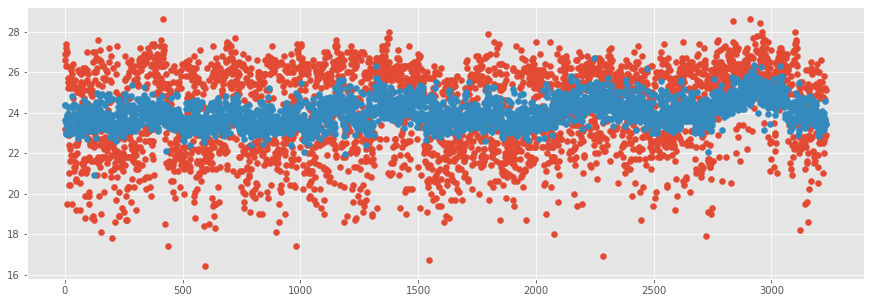

In [339]:
plt.figure(figsize=(15,5))
plt.scatter(range(pred_df.shape[0]),pred_df['true'])
plt.scatter(range(pred_df.shape[0]),pred_df['pred'])

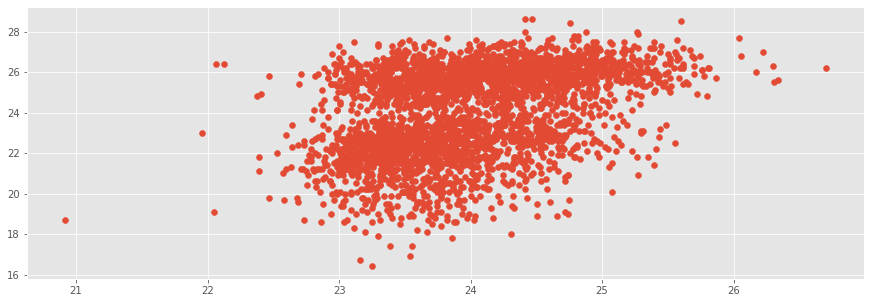

In [340]:
plt.figure(figsize=(15,5))
plt.scatter(pred_df['pred'],pred_df['true'])